# Impact of clustering on classification results, and stats

The purpose of this notebook is to observe how the data responds to being clustered by cd-hit at different thresholds.

In a second step, we perform deterministic randomized undersampling, to determine the smallest number of samples that leads to good classification results.

Then, we undersample the majority class, to test whether that makes its score approach that of the minority class.

Finally, we recreated some of the plots from Notebook 2, after a 70% cluster threshold has been applied.

## Imports

In [19]:
from subpred.transporter_dataset import create_dataset, get_clustering_stats
from subpred.compositions import calculate_aac, calculate_paac
from subpred.plots import (
    labeled_clustermap,
    pca_plot_2d,
    pca_plot_3d,
    feature_importance_plot,
    downsampling_plot, downsample_majority_class_plot
)
from subpred.cdhit import cd_hit
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = create_dataset(
    keywords_substrate_filter=["Amino-acid transport", "Sugar transport"],
    keywords_component_filter=["Transmembrane"],
    keywords_transport_filter=["Transport"],
    input_file="../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate="integrate",
    verbose=True,
    tax_ids_filter=[3702, 9606, 83333, 559292],
    output_log="../logs/meta_amino_sugar_dataset.log",
    outliers=["Q9HBR0", "Q07837"]  # human
    + ["P76773", "Q47706", "P02943", "P75733", "P69856", "P64550"]  # Ecoli
    + [
        "O81775",
        "Q9SW07",
        "Q9FHH5",
        "Q8S8A0",
        "Q3E965",
        "Q3EAV6",
        "Q3E8L0",
    ],  # athliana
)
taxid_to_organism = {
    3702: "A. thaliana",
    9606: "Human",
    83333: "E. coli",
    559292: "Yeast",
}
df = df.assign(organism=df.organism_id.map(taxid_to_organism))


## Stats

In [5]:
df_stats_long = get_clustering_stats(
    df,
    keyword_types=[
        "keywords_transport",
        "keywords_location",
        "keywords_transport_related",
        "tcdb_class",
        "organism",
    ],
)
df_stats_long


,identity_threshold,kw_type,keyword,count
0,40,keywords_location,Cell inner membrane,87
1,40,keywords_location,Cell membrane,117
2,40,keywords_location,Endoplasmic reticulum,15
3,40,keywords_location,Membrane,223
4,40,keywords_location,Mitochondrion,8
...,...,...,...,...
145,100,organism,Yeast,64
146,100,tcdb_class,0.0,123
147,100,tcdb_class,2.A,250
148,100,tcdb_class,3.A,23


In [6]:
def pivot(df_stats_long, kw_type):
    return df_stats_long[df_stats_long.kw_type == kw_type].pivot(
        index="identity_threshold", columns="keyword", values="count"
    ).fillna(0).convert_dtypes(int)

keyword,A. thaliana,E. coli,Human,Yeast
identity_threshold,,,,
40,52,88,47,36
50,78,93,64,40
60,103,94,77,44
70,117,98,81,51
80,135,99,84,58
90,156,99,84,60
100,165,99,85,64


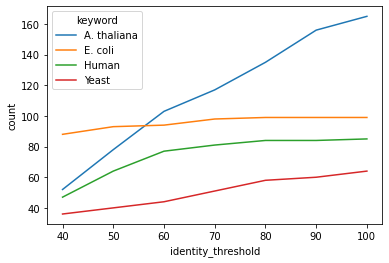

In [9]:
sns.lineplot(
    data=df_stats_long[df_stats_long.kw_type == "organism"],
    x="identity_threshold",
    y="count",
    hue="keyword",
)
pivot(df_stats_long, "organism")

The number of A Thaliana transporters drops much more sharply in A thaliana than in the other organisms at low thresholds. Human drops more at 60%, yeast at 80.

keyword,Amino-acid transport,Sugar transport
identity_threshold,,
40,113,110
50,137,138
60,152,166
70,166,181
80,179,197
90,184,215
100,185,228


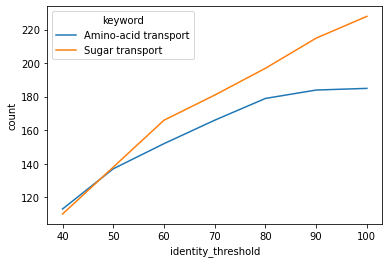

In [22]:
sns.lineplot(
    data=df_stats_long[df_stats_long.kw_type == "keywords_transport"],
    x="identity_threshold",
    y="count",
    hue="keyword",
)
pivot(df_stats_long, "keywords_transport")

Most of the proteins are removed from Transmembrane, which coincides with total transporters in the dataset, as Transmembrane was a filtering criterion when creating the dataset:

keyword,Cell inner membrane,Cell membrane,Endoplasmic reticulum,Membrane,Mitochondrion,Mitochondrion inner membrane,Nucleus,Plastid inner membrane,Transmembrane
identity_threshold,,,,,,,,,
40,87,117,15,223,8,2,0,1,223
50,92,143,18,275,8,2,0,1,275
60,93,160,18,318,10,3,0,1,318
70,97,174,19,347,10,3,0,1,347
80,98,187,21,376,12,3,1,1,376
90,98,195,22,399,12,3,1,1,399
100,98,199,22,413,12,3,1,1,413


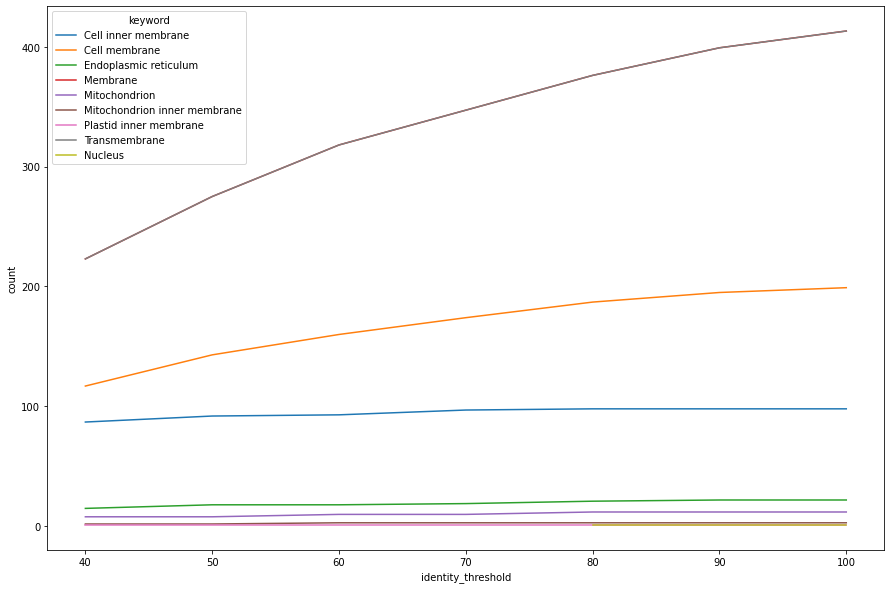

In [21]:
plt.figure(figsize=(15,10))
sns.lineplot(
    data=df_stats_long[df_stats_long.kw_type == "keywords_location"],
    x="identity_threshold",
    y="count",
    hue="keyword",
)
pivot(df_stats_long, "keywords_location")

Transport systems:

keyword,Antiport,Symport,Transport
identity_threshold,,,
40,15,33,223
50,18,44,275
60,19,57,318
70,21,62,347
80,22,71,376
90,27,79,399
100,29,80,413


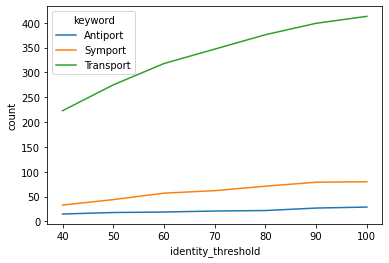

In [23]:
sns.lineplot(
    data=df_stats_long[df_stats_long.kw_type == "keywords_transport_related"],
    x="identity_threshold",
    y="count",
    hue="keyword",
)
pivot(df_stats_long, "keywords_transport_related")

The 3.A and 4.A transporters stay constant, they do not seem to have a sequence similarity of 40%, unlike the other transporters.

keyword,0.0,2.A,3.A,4.A
identity_threshold,,,,
40,38,146,23,16
50,55,180,23,17
60,72,206,23,17
70,84,223,23,17
80,100,236,23,17
90,114,245,23,17
100,123,250,23,17


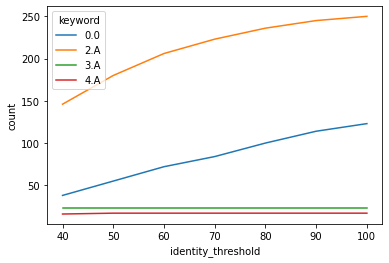

In [24]:
sns.lineplot(
    data=df_stats_long[df_stats_long.kw_type == "tcdb_class"],
    x="identity_threshold",
    y="count",
    hue="keyword",
)
pivot(df_stats_long, "tcdb_class")

The performance drops when the number of samples is below a certain threshold of transporters per organism. The actual scores should be better than this unoptimized model.

<AxesSubplot:xlabel='Total Samples', ylabel='Score'>

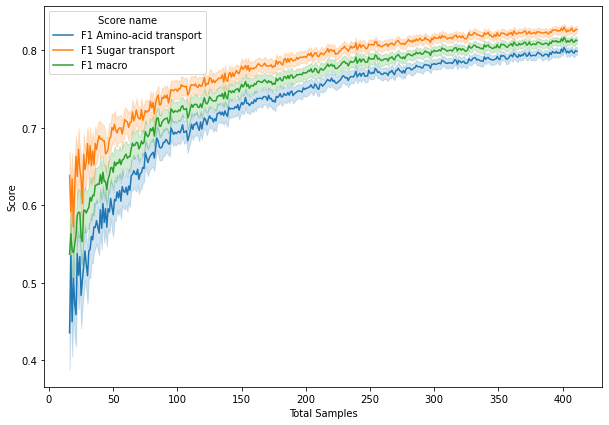

In [25]:
df_aac = calculate_aac(df.sequence)
labels = df.keywords_transport.rename("labels")

downsampling_plot(df_aac, labels)

When downsampling the majority class until the dataset is balanced, the performance starts to match that of the minority class. 

<AxesSubplot:xlabel='|Amino-acid transport|/|Sugar transport|', ylabel='Score'>

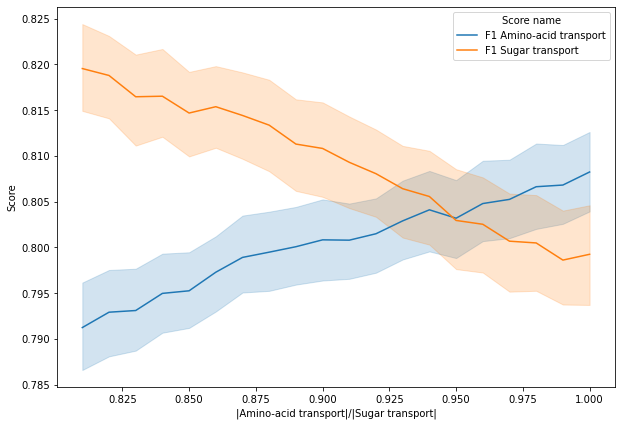

In [31]:
df_aac = calculate_aac(df.sequence)
labels = df.keywords_transport.rename("labels")
downsample_majority_class_plot(
    df_aac,
    labels,
    n_jobs=-1,
    min_class_sample_fractions=[x / 100 for x in range(81, 101)],
    include_macro=False,
)



## Plots at 70% cluster threshold


66 proteins are removed at 70% clustering threshold, mostly from AT.

In [32]:
cluster_representatives_70 = cd_hit(df.sequence, identity_threshold=70)
df_clustered = df.loc[cluster_representatives_70]

cd-hit: clustered 413 sequences into 347 clusters at threshold 70


In [34]:
df_aac_clustered = calculate_aac(df_clustered.sequence)
df_paac_clustered = calculate_paac(df_clustered.sequence)
labels_clustered = df_clustered.keywords_transport.rename("labels")

### Feature importance


Again, the frequency of Glutamic acid is the most important feature. This was also the case in A thaliana and in Yeast. Glycine, which as in first place for E Coli and Human, is in fourth place. 

<AxesSubplot:xlabel='Feature', ylabel='Normalized score'>

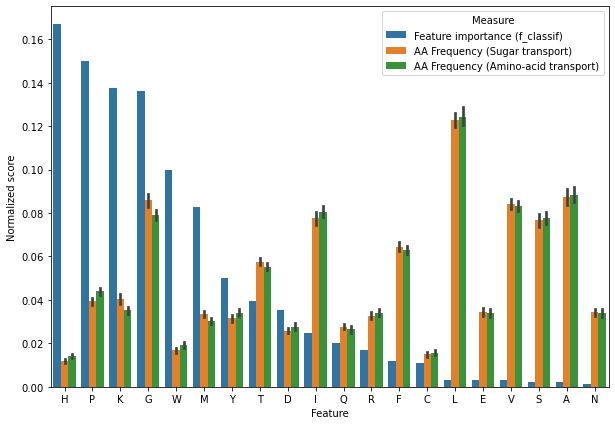

In [35]:
feature_importance_plot(df_aac_clustered, labels_clustered, method="f_classif")

### PCA



#### AAC

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

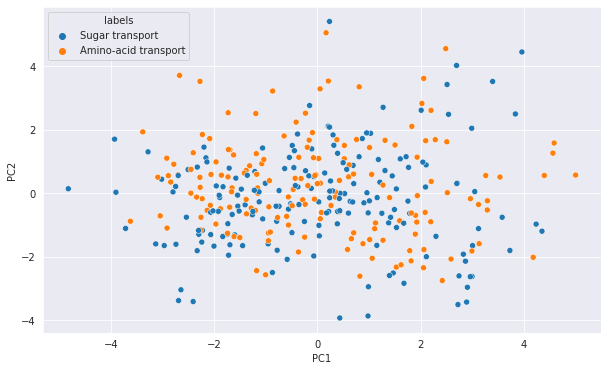

In [37]:
pca_plot_2d(df_aac_clustered, labels_clustered)

#### PAAC

The PAAC looks different after clustering, the pattern of AA transporters having lower variance is less noticable. 

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

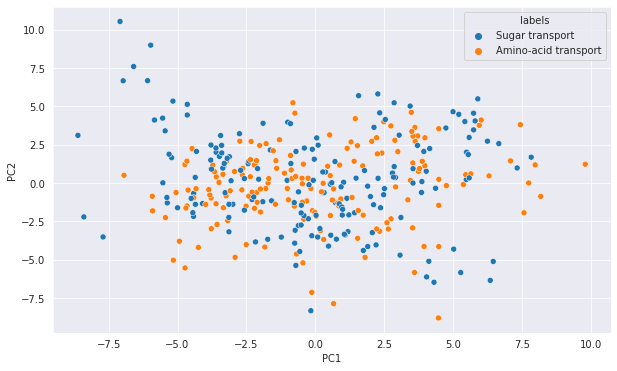

In [50]:

pca_plot_2d(df_paac_clustered, labels_clustered)


This might be because a lot of the surrounding sugar transporters have been removed:

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

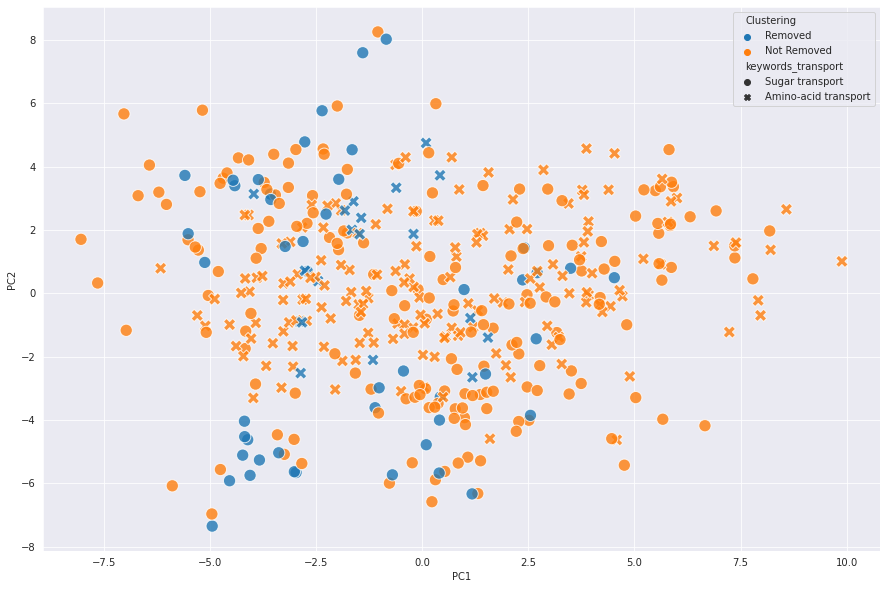

In [51]:
pca_plot_2d(
    calculate_paac(df.sequence),
    df.index.to_series()
    .transform(
        lambda x: "Not Removed" if x in df_paac_clustered.index else "Removed"
    )
    .rename("Clustering"),
    df.keywords_transport,
    figsize=(15,10),
    marker_size=150,
    marker_opacity=0.8
)

<Axes3DSubplot:xlabel='PC1', ylabel='PC2'>

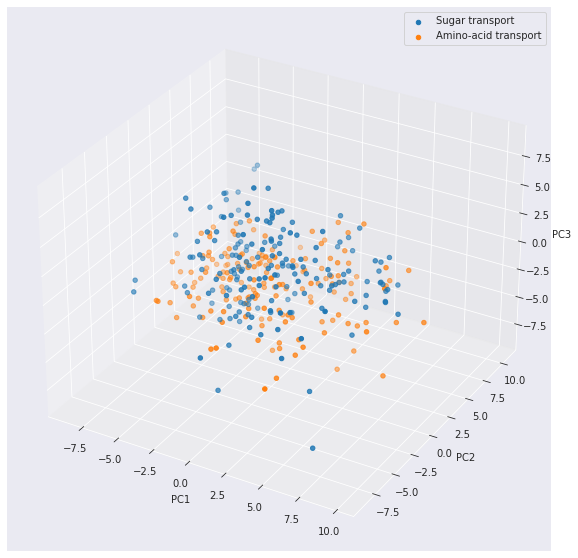

In [39]:
pca_plot_3d(df_paac_clustered, labels_clustered)

As for TCDB classes, the class 3 and class 4 transporters are still located in an E coli cluster:

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

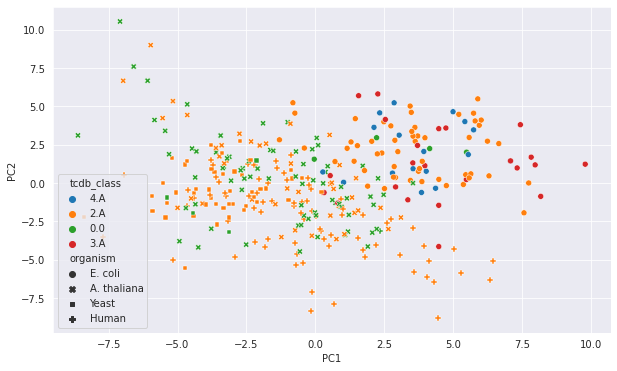

In [54]:
pca_plot_2d(df_paac_clustered, df_clustered.tcdb_class, df_clustered.organism)

## Clustering heatmaps

Classes are still not separable very well through hierarchical clustering

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7f0f9e5998b0>)

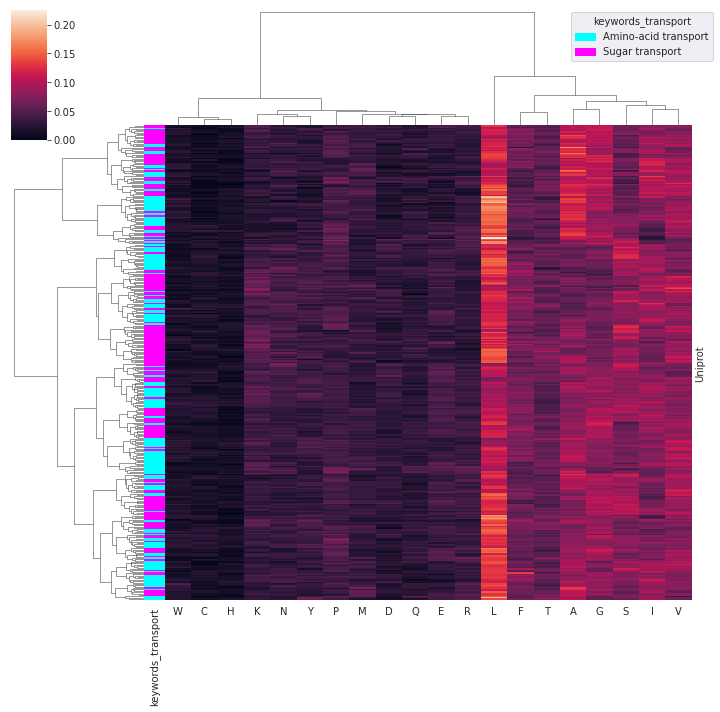

In [56]:
labeled_clustermap(df_aac_clustered, df_clustered.keywords_transport, xlabels="auto")


The same is true for paac:

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7f0fa6f0f370>)

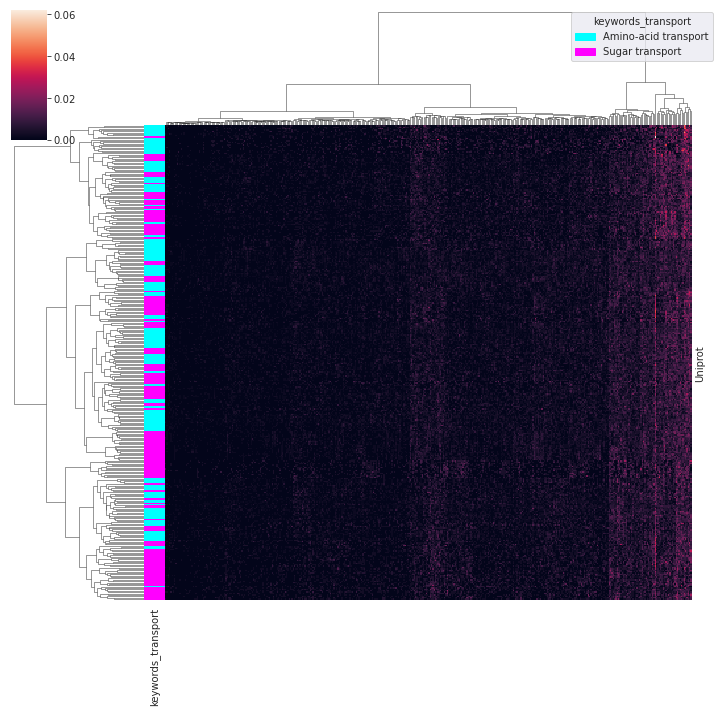

In [57]:
labeled_clustermap(df_paac_clustered, df_clustered.keywords_transport)

The unclassified transporters from AT mix in well with the remaining organisms: 

({'0.0': 'cyan', '2.A': 'magenta', '3.A': 'yellow', '4.A': 'green'},
 <seaborn.matrix.ClusterGrid at 0x7f0fac597370>)

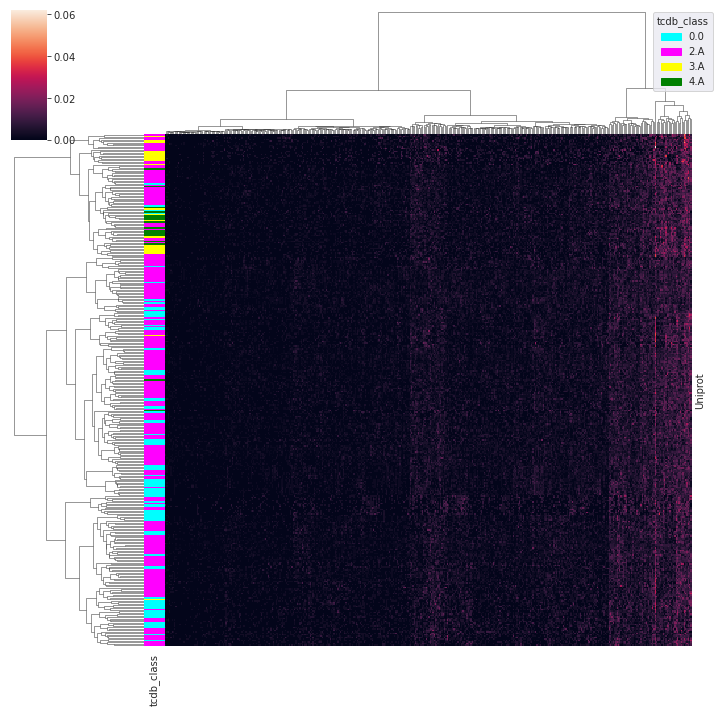

In [58]:
labeled_clustermap(df_paac_clustered, df_clustered.tcdb_class)

({'Antiport;Symport;Transport': 'cyan',
  'Antiport;Transport': 'magenta',
  'Symport;Transport': 'yellow',
  'Transport': 'green'},
 <seaborn.matrix.ClusterGrid at 0x7f0fb3bd86a0>)

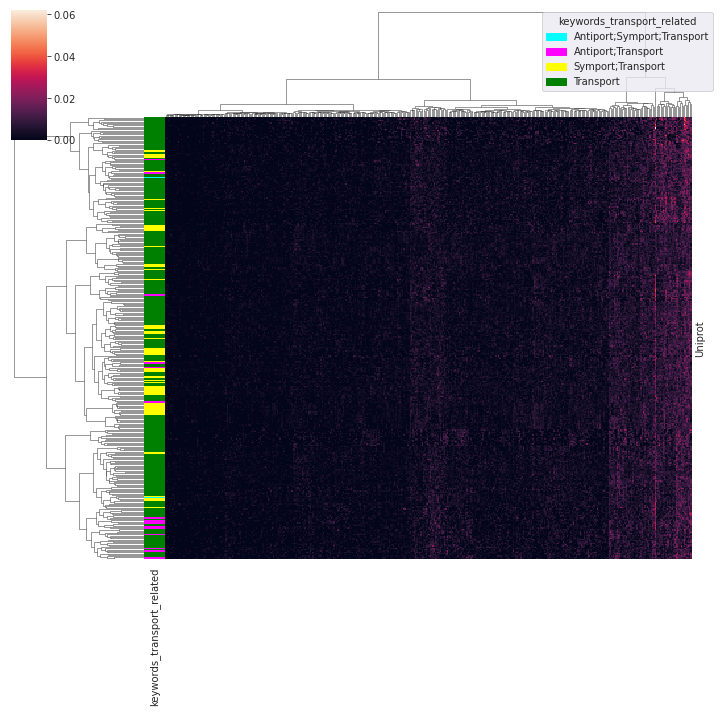

In [59]:
labeled_clustermap(df_paac_clustered, df_clustered.keywords_transport_related)